# The Python API

This document builds up on [our "Get Started" guide](https://mics-lab.github.io/lincs/get-started.html) and our [user guide](https://mics-lab.github.io/lincs/user-guide.html), and introduces *lincs*' Python API.
This API is more flexible, albeit more complex, than the command-line interface you've been using so far.

If you're a Jupyter user, you can [download the notebook](python-api/python-api.ipynb) this document is based on.

## Do it again, in Python

First, lets do exactly the same thing as in our "Get started" guide, but using the Python API.

In [1]:
from lincs import classification as lc

Generate a synthetic classification problem:

In [2]:
problem = lc.generate_problem(criteria_count=4, categories_count=3, random_seed=40)

The first difference with the command-line interface is the third argument to the call to `generate_problem`: it's the pseudo-random seed optionally passed by the `--random-seed` option on the command line. All pseudo-random seeds are mandatory in the Python API, so that you have full control of reproducibility. If you don't care about it, you can use `random.randrange(2**30)` to use pseudo-random pseudo-random seeds. (No typo here: the pseudo-random seeds are pseudo-random.)

Generated problems are returned as Python objects of class `lincs.Problem`. You can print them:

In [3]:
import sys
problem.dump(sys.stdout)

kind: classification-problem
format_version: 1
criteria:
  - name: Criterion 1
    value_type: real
    preference_direction: increasing
    min_value: 0
    max_value: 1
  - name: Criterion 2
    value_type: real
    preference_direction: increasing
    min_value: 0
    max_value: 1
  - name: Criterion 3
    value_type: real
    preference_direction: increasing
    min_value: 0
    max_value: 1
  - name: Criterion 4
    value_type: real
    preference_direction: increasing
    min_value: 0
    max_value: 1
ordered_categories:
  - name: Worst category
  - name: Intermediate category 1
  - name: Best category


Description functions generate a list of strings:

In [4]:
print("\n".join(lc.describe_problem(problem)))

This a classification problem into 3 ordered categories named "Worst category", "Intermediate category 1" and "Best category".
The best category is "Best category" and the worst category is "Worst category".
There are 4 classification criteria (in no particular order).
Criterion "Criterion 1" takes real values between 0.0 and 1.0 included.
Higher values of "Criterion 1" are known to be better.
Criterion "Criterion 2" takes real values between 0.0 and 1.0 included.
Higher values of "Criterion 2" are known to be better.
Criterion "Criterion 3" takes real values between 0.0 and 1.0 included.
Higher values of "Criterion 3" are known to be better.
Criterion "Criterion 4" takes real values between 0.0 and 1.0 included.
Higher values of "Criterion 4" are known to be better.


Generate a synthetic MR-Sort classification model, again with an explicit pseudo-random seed:

In [5]:
model = lc.generate_mrsort_model(problem, random_seed=41)

model.dump(problem, sys.stdout)

kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [0.255905151, 0.676961303]
  - kind: thresholds
    thresholds: [0.0551739037, 0.324553937]
  - kind: thresholds
    thresholds: [0.162252158, 0.673279881]
  - kind: thresholds
    thresholds: [0.0526000932, 0.598555863]
sufficient_coalitions:
  - &coalitions
    kind: weights
    criterion_weights: [0.147771254, 0.618687689, 0.406786472, 0.0960085914]
  - *coalitions


Visualization functions interface with [Matplotlib](https://matplotlib.org/):

In [6]:
import matplotlib.pyplot as plt

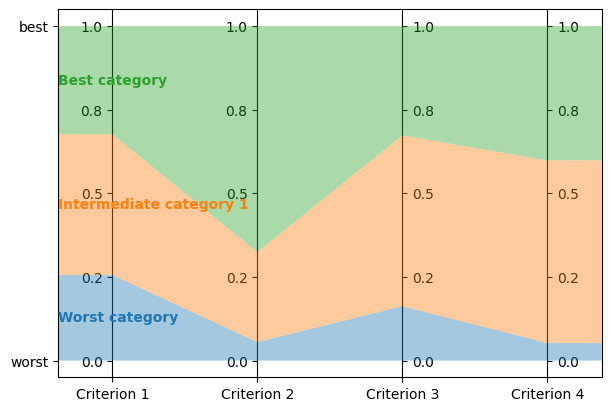

In [7]:
axes = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")[1]
lc.visualize_model(problem, model, [], axes)

Get the model's description:

In [8]:
print("\n".join(lc.describe_model(problem, model)))

This is a MR-Sort (a.k.a. 1-Uc-NCS) model: an NCS model where the sufficient coalitions are specified using the same criterion weights for all boundaries.
The weights associated to each criterion are:
  - Criterion "Criterion 1": 0.15
  - Criterion "Criterion 2": 0.62
  - Criterion "Criterion 3": 0.41
  - Criterion "Criterion 4": 0.10
To get into an upper category, an alternative must be accepted by the following boundaries on a set of criteria whose weights add up to at least 1:
  - For category "Intermediate category 1": at least 0.26 on criterion "Criterion 1", at least 0.06 on criterion "Criterion 2", at least 0.16 on criterion "Criterion 3", and at least 0.05 on criterion "Criterion 4"
  - For category "Best category": at least 0.68 on criterion "Criterion 1", at least 0.32 on criterion "Criterion 2", at least 0.67 on criterion "Criterion 3", and at least 0.60 on criterion "Criterion 4"


Generate a synthetic learning set (with an explicit pseudo-random seed):

In [9]:
learning_set = lc.generate_alternatives(problem, model, alternatives_count=1000, random_seed=42)

Dump it (in memory instead of on `sys.stdout` to print only the first few lines):

In [10]:
import io
f = io.StringIO()
learning_set.dump(problem, f)
print("\n".join(f.getvalue().splitlines()[:6] + ['...']))

name,"Criterion 1","Criterion 2","Criterion 3","Criterion 4",category
"Alternative 1",0.37454012,0.796543002,0.95071429,0.183434784,"Best category"
"Alternative 2",0.731993914,0.779690981,0.598658502,0.596850157,"Intermediate category 1"
"Alternative 3",0.156018645,0.445832759,0.15599452,0.0999749228,"Worst category"
"Alternative 4",0.0580836125,0.4592489,0.866176128,0.333708614,"Best category"
"Alternative 5",0.601114988,0.14286682,0.708072603,0.650888503,"Intermediate category 1"
...


Visualize it:

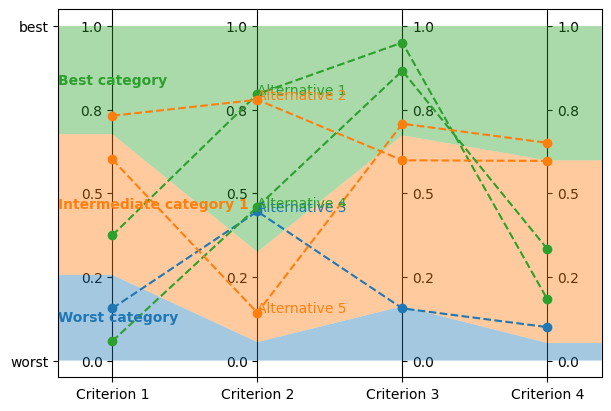

In [11]:
axes = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")[1]
lc.visualize_model(problem, model, learning_set.alternatives[:5], axes)

Let's now train a new model from this synthetic learning set.
The command-line interface of `lincs learn classification-model` accepts quite a few options.
Most of them set up the strategies used for the learning, as described further in our [user guide](https://mics-lab.github.io/lincs/user-guide.html).
When using the Python API, you have to create these strategies yourself:

In [12]:
preprocessed_learning_set = lc.PreprocessedLearningSet(problem, learning_set)
models_being_learned = lc.LearnMrsortByWeightsProfilesBreed.ModelsBeingLearned(preprocessed_learning_set, models_count=9, random_seed=43)
profiles_initialization_strategy = lc.InitializeProfilesForProbabilisticMaximalDiscriminationPowerPerCriterion(preprocessed_learning_set, models_being_learned)
weights_optimization_strategy = lc.OptimizeWeightsUsingGlop(preprocessed_learning_set, models_being_learned)
profiles_improvement_strategy = lc.ImproveProfilesWithAccuracyHeuristicOnCpu(preprocessed_learning_set, models_being_learned)
breeding_strategy = lc.ReinitializeLeastAccurate(models_being_learned, profiles_initialization_strategy=profiles_initialization_strategy, count=4)
termination_strategy = lc.TerminateAtAccuracy(models_being_learned, target_accuracy=len(learning_set.alternatives))

Then create the learning itself:

In [13]:
learning = lc.LearnMrsortByWeightsProfilesBreed(
    preprocessed_learning_set,
    models_being_learned,
    profiles_initialization_strategy,
    weights_optimization_strategy,
    profiles_improvement_strategy,
    breeding_strategy,
    termination_strategy,
)

And `.perform` it to create the learned `Model` object:

In [14]:
learned_model = learning.perform()
learned_model.dump(problem, sys.stdout)

kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [0.339874953, 0.421424538]
  - kind: thresholds
    thresholds: [0.0556534864, 0.326433569]
  - kind: thresholds
    thresholds: [0.162616938, 0.67343241]
  - kind: thresholds
    thresholds: [0.0878681168, 0.252649099]
sufficient_coalitions:
  - &coalitions
    kind: weights
    criterion_weights: [0, 1.01327896e-06, 0.999998987, 0]
  - *coalitions


Create a testing set and classify it, taking notes of the accuracy of the new model on that testing set:

In [15]:
testing_set = lc.generate_alternatives(problem, model, alternatives_count=3000, random_seed=44)
classification_result = lc.classify_alternatives(problem, learned_model, testing_set)
classification_result.changed, classification_result.unchanged

(4, 2996)

This covers what was done in our "Get started" guide.
As you can see the Python API is more verbose, but for good reasons: it's more powerful as you'll see in the next section.

## Do more, with the Python API

### Create classification objects

You don't have to use our pseudo-random generation functions; you can create `Problem`, `Model`, *etc.* instances yourself.

#### Create a `Problem`

In [16]:
problem = lc.Problem(
    criteria=[
        lc.Criterion("Physics grade", lc.Criterion.IntegerValues(lc.Criterion.PreferenceDirection.increasing, 0, 100)),
        lc.Criterion("Literature grade", lc.Criterion.EnumeratedValues(["f", "e", "d", "c", "b", "a"])),
    ],
    ordered_categories=[lc.Category("Failed"), lc.Category("Passed"), lc.Category("Congratulations")],
)

problem.dump(sys.stdout)

kind: classification-problem
format_version: 1
criteria:
  - name: Physics grade
    value_type: integer
    preference_direction: increasing
    min_value: 0
    max_value: 100
  - name: Literature grade
    value_type: enumerated
    ordered_values: [f, e, d, c, b, a]
ordered_categories:
  - name: Failed
  - name: Passed
  - name: Congratulations


You can access all their attributes in code as well:

In [17]:
criterion = problem.criteria[0]

In [18]:
criterion.name

'Physics grade'

In [19]:
criterion.value_type, criterion.is_real, criterion.is_integer, criterion.is_enumerated

(<ValueType.integer: 1>, False, True, False)

In [20]:
values = criterion.integer_values

In [21]:
values.preference_direction, values.is_increasing, values.is_decreasing

(<PreferenceDirection.increasing: 0>, True, False)

In [22]:
values.min_value, values.max_value

(0, 100)

In [23]:
criterion = problem.criteria[1]

In [24]:
criterion.name

'Literature grade'

In [25]:
criterion.value_type, criterion.is_real, criterion.is_integer, criterion.is_enumerated

(<ValueType.enumerated: 2>, False, False, True)

In [26]:
values = criterion.enumerated_values

In [27]:
list(values.ordered_values)

['f', 'e', 'd', 'c', 'b', 'a']

In [28]:
values.get_value_rank(value="a")

5

#### Create a `Model`

In [29]:
model = lc.Model(
    problem,
    accepted_values=[
        lc.AcceptedValues(lc.AcceptedValues.IntegerThresholds([50, 80])),
        lc.AcceptedValues(lc.AcceptedValues.EnumeratedThresholds(["c", "a"])),
    ],
    sufficient_coalitions=[
        lc.SufficientCoalitions(lc.SufficientCoalitions.Weights([0.5, 0.5])),
        lc.SufficientCoalitions(lc.SufficientCoalitions.Weights([0.5, 0.5])),
    ],
)

model.dump(problem, sys.stdout)

kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [50, 80]
  - kind: thresholds
    thresholds: [c, a]
sufficient_coalitions:
  - &coalitions
    kind: weights
    criterion_weights: [0.5, 0.5]
  - *coalitions


In [30]:
accepted = model.accepted_values[0]

In [31]:
accepted.value_type, accepted.is_real, accepted.is_integer, accepted.is_enumerated

(<ValueType.integer: 1>, False, True, False)

In [32]:
accepted.kind, accepted.is_thresholds

(<Kind.thresholds: 0>, True)

In [33]:
list(accepted.integer_thresholds.thresholds)

[50, 80]

In [34]:
accepted = model.accepted_values[1]

In [35]:
accepted.value_type, accepted.is_real, accepted.is_integer, accepted.is_enumerated

(<ValueType.enumerated: 2>, False, False, True)

In [36]:
accepted.kind, accepted.is_thresholds

(<Kind.thresholds: 0>, True)

In [37]:
list(accepted.enumerated_thresholds.thresholds)

['c', 'a']

In [38]:
sufficient = model.sufficient_coalitions[0]

In [39]:
sufficient.kind, sufficient.is_weights, sufficient.is_roots

(<Kind.weights: 0>, True, False)

In [40]:
list(sufficient.weights.criterion_weights)

[0.5, 0.5]

#### Create (classified) `Alternatives`

In [41]:
alternatives = lc.Alternatives(problem, [
    lc.Alternative(
        "Unclassified alternative",
        [
            lc.Performance(lc.Performance.Integer(50)),
            lc.Performance(lc.Performance.Enumerated("c")),
        ],
        None
    ),
    lc.Alternative(
        "Classified alternative",
        [
            lc.Performance(lc.Performance.Integer(90)),
            lc.Performance(lc.Performance.Enumerated("a")),
        ],
        2
    ),
])

In [42]:
alternative = alternatives.alternatives[0]

In [43]:
alternative.category_index is None

True

In [44]:
performance = alternative.profile[0]

In [45]:
performance.value_type, performance.is_real, performance.is_integer, performance.is_enumerated

(<ValueType.integer: 1>, False, True, False)

In [46]:
performance.integer.value

50

In [47]:
problem.ordered_categories[alternatives.alternatives[1].category_index].name

'Congratulations'

### Clone classification objects

Just use [`copy.deepcopy`](https://docs.python.org/3/library/copy.html#copy.deepcopy):

In [48]:
import copy

copied_problem = copy.deepcopy(problem)
copied_model = copy.deepcopy(model)
copied_alternatives = copy.deepcopy(alternatives)

This is especially useful *e.g.* if you want to identify alternatives that are classified differently by two models, because `lc.classify_alternatives` mutates the alternatives: clone the `Alternatives`, classify the copy and iterate over the [`zip`](https://docs.python.org/3/library/functions.html#zip) of both `Alternatives`, comparing their `.category_index`.

### Serialize classification objects

#### In YAML and CSV like the command-line

(and the upcoming C++ API)

Classification objects have a `.dump` method, and their classes have a static `.load` method that accept file-like objects.

We've used them above to print classification objects to `sys.stdout`. Here is an example of how to use them with actual files:

In [49]:
with open("problem.yml", "w") as f:
    problem.dump(f)

with open("model.yml", "w") as f:
    model.dump(problem, f)

with open("alternatives.csv", "w") as f:
    alternatives.dump(problem, f)

with open("problem.yml") as f:
    problem = lc.Problem.load(f)

with open("model.yml") as f:
    model = lc.Model.load(problem, f)

with open("alternatives.csv") as f:
    alternatives = lc.Alternatives.load(problem, f)

And here with in-memory [io](https://docs.python.org/3/library/io.html) objects:

In [50]:
f = io.StringIO()
problem.dump(f)
s = f.getvalue()
print(s)

kind: classification-problem
format_version: 1
criteria:
  - name: Physics grade
    value_type: integer
    preference_direction: increasing
    min_value: 0
    max_value: 100
  - name: Literature grade
    value_type: enumerated
    ordered_values: [f, e, d, c, b, a]
ordered_categories:
  - name: Failed
  - name: Passed
  - name: Congratulations



In [51]:
f = io.StringIO(s)
problem = lc.Problem.load(f)

#### Using the Python-specific `pickle` module

Classification objects simply support [pickling](https://docs.python.org/3/library/pickle.html) and unpickling. We recommend using the YAML and CSV formats whenever possible because they are not tied to the Python language (or the *lincs* library for that matter).

In [52]:
import pickle

pickle.loads(pickle.dumps(problem)).dump(sys.stdout)

kind: classification-problem
format_version: 1
criteria:
  - name: Physics grade
    value_type: integer
    preference_direction: increasing
    min_value: 0
    max_value: 100
  - name: Literature grade
    value_type: enumerated
    ordered_values: [f, e, d, c, b, a]
ordered_categories:
  - name: Failed
  - name: Passed
  - name: Congratulations


Note however that learning objects (*e.g.* instances of `LearnMrsortByWeightsProfilesBreed`) are *not* picklable.

### Customize the model visualization

We've decided to not implement any customization for the visualizations produced by `lincs.classification.visualize_model` (and thus `lincs visualize classification-model`) because this would make it less robust and increase its complexity beyond the scope of *lincs*.

However, `lincs.classification.visualize_model` is written in Python, using the Python API described in this guide. This means that you can get inspiration from its [source code](https://github.com/MICS-Lab/lincs/blob/main/lincs/visualization.py) (*i.e.* copy-paste it) to produce custom visualizations for your needs.

Be aware that our implementation supports a few edge cases, so it might be a bit more complex than what you actually need:

- problems and models with a single criterion are visualized in a sensible way

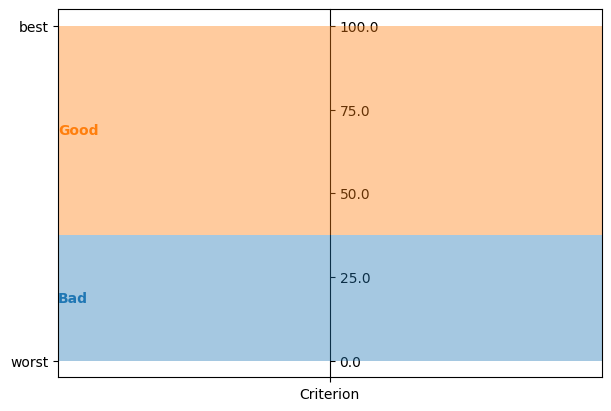

In [53]:
problem = lc.Problem([lc.Criterion("Criterion", lc.Criterion.RealValues(lc.Criterion.PreferenceDirection.increasing, 0, 100))], [lc.Category("Bad"), lc.Category("Good")])
model = lc.generate_mrsort_model(problem, 42)
axes = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")[1]
lc.visualize_model(problem, model, [], axes)

- all value types (real, integer and enumerated) are visualized on vertical axes

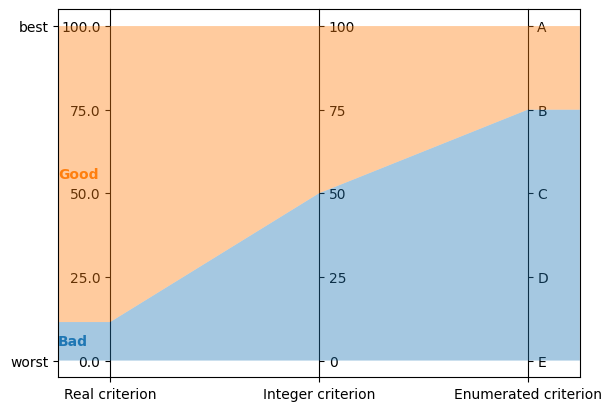

In [54]:
problem = lc.Problem(
    [
        lc.Criterion("Real criterion", lc.Criterion.RealValues(lc.Criterion.PreferenceDirection.increasing, 0, 100)),
        lc.Criterion("Integer criterion", lc.Criterion.IntegerValues(lc.Criterion.PreferenceDirection.increasing, 0, 100)),
        lc.Criterion("Enumerated criterion", lc.Criterion.EnumeratedValues(["E", "D", "C", "B", "A"])),
    ],
    [lc.Category("Bad"), lc.Category("Good")]
)
model = lc.generate_mrsort_model(problem, 43)
axes = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")[1]
lc.visualize_model(problem, model, [], axes)

- increasing and decreasing criteria are visualized with axes going up or down

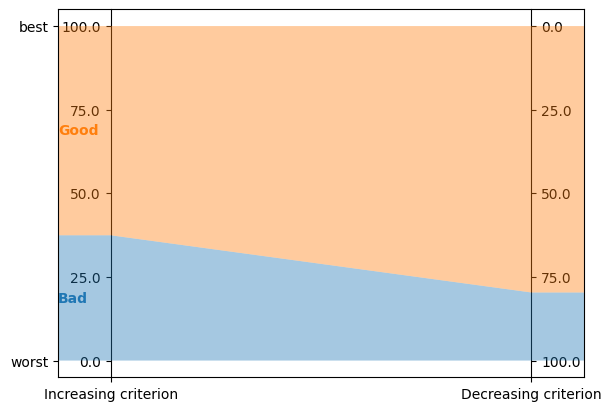

In [55]:
problem = lc.Problem(
    [
        lc.Criterion("Increasing criterion", lc.Criterion.RealValues(lc.Criterion.PreferenceDirection.increasing, 0, 100)),
        lc.Criterion("Decreasing criterion", lc.Criterion.RealValues(lc.Criterion.PreferenceDirection.decreasing, 0, 100)),
    ],
    [lc.Category("Bad"), lc.Category("Good")]
)
model = lc.generate_mrsort_model(problem, 42)
axes = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")[1]
lc.visualize_model(problem, model, [], axes)

- any min and max values are aligned horizontally at the top and bottom of vertical axes

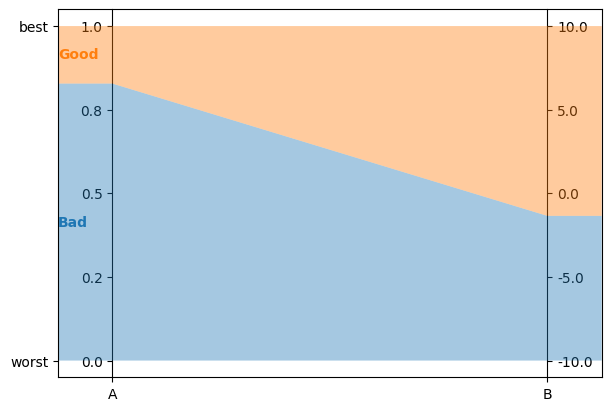

In [56]:
problem = lc.Problem(
    [
        lc.Criterion("A", lc.Criterion.RealValues(lc.Criterion.PreferenceDirection.increasing, 0, 1)),
        lc.Criterion("B", lc.Criterion.RealValues(lc.Criterion.PreferenceDirection.increasing, -10, 10)),
    ],
    [lc.Category("Bad"), lc.Category("Good")]
)
model = lc.generate_mrsort_model(problem, 44)
axes = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")[1]
lc.visualize_model(problem, model, [], axes)

- labels for integer criteria with any number of intervals

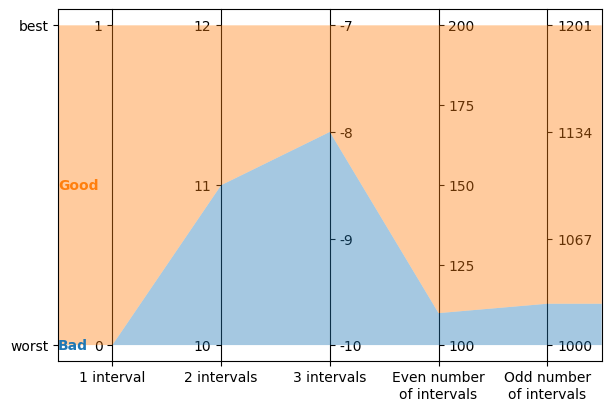

In [57]:
problem = lc.Problem(
    [
        lc.Criterion("1 interval", lc.Criterion.IntegerValues(lc.Criterion.PreferenceDirection.increasing, 0, 1)),
        lc.Criterion("2 intervals", lc.Criterion.IntegerValues(lc.Criterion.PreferenceDirection.increasing, 10, 12)),
        lc.Criterion("3 intervals", lc.Criterion.IntegerValues(lc.Criterion.PreferenceDirection.increasing, -10, -7)),
        lc.Criterion("Even number\nof intervals", lc.Criterion.IntegerValues(lc.Criterion.PreferenceDirection.increasing, 100, 200)),
        lc.Criterion("Odd number\nof intervals", lc.Criterion.IntegerValues(lc.Criterion.PreferenceDirection.increasing, 1000, 1201)),
    ],
    [lc.Category("Bad"), lc.Category("Good")]
)
model = lc.generate_mrsort_model(problem, 43)
axes = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")[1]
lc.visualize_model(problem, model, [], axes)

### Create your own learning strategies

The "Weights, profiles, breed" learning approach uses strategies for each of its steps. *lincs* provides effective strategies as you've seen in the first part of this guide. You can also define your own strategies, to experiment with new ways to learn.

Let's create a problem and learning set for this section:

In [58]:
problem = lc.Problem(
    [
        lc.Criterion("Criterion 1", lc.Criterion.RealValues(lc.Criterion.PreferenceDirection.decreasing, 0, 10)),
        lc.Criterion("Criterion 2", lc.Criterion.IntegerValues(lc.Criterion.PreferenceDirection.increasing, 0, 100)),
        lc.Criterion("Criterion 3", lc.Criterion.EnumeratedValues(["F", "E", "D", "C", "B", "A"])),
    ],
    [lc.Category("Bad"), lc.Category("Medium"), lc.Category("Good")],
)
learning_set = lc.generate_alternatives(problem, lc.generate_mrsort_model(problem, random_seed=42), alternatives_count=1000, random_seed=43)

#### `PreprocessedLearningSet`

First, let's get more familiar with `PreprocessedLearningSet` and `ModelsBeingLearned`.
You've seen them briefly in the first part of this guide but their purpose might still be quite obscure at this point.

In [59]:
preprocessed_learning_set = lc.PreprocessedLearningSet(problem, learning_set)

Learning algorithms don't need to know if a criterion has `integer` or `real` values, or if it has `increasing` or `decreasing` preference direction.
The `PreprocessedLearningSet` gives them a simplified, unified view in the form of parformance "ranks": for each alternative, on each criterion, it contains the rank of that alternatives performance. This is like having only `increasing` `integer` criteria taking consecuteive values up from zero with no gaps.

First, it provides the different counts from the problem and learning set, in a unified way:

In [60]:
(preprocessed_learning_set.criteria_count, preprocessed_learning_set.categories_count, preprocessed_learning_set.boundaries_count, preprocessed_learning_set.alternatives_count)

(3, 3, 2, 1000)

The number of distinct values actually seen for each criterion (including the min and max values for numerical criteria):

In [61]:
list(preprocessed_learning_set.values_counts)  # Indexed by [criterion_index]

[1002, 101, 6]

We see that the learning data knows 1002 values for the real-valued criterion. This is usual as it's rare for two floating point values to be exactly equal, so the 1000 alternatives have distinct values, and the min and max are two more values. The learning data contains 101 values for the integer-valued criterion, meaning that the alternatives in the learning set do actually cover the whole set of possible values. And similarly, 6 values for the enumerated criterion.

For each criterion, the ranks of the performance of each alternative:

In [62]:
[list(v)[:10] + ['...'] for v in preprocessed_learning_set.performance_ranks]  # Indexed by [criterion_index][alternative_index]

[[883, 900, 753, 216, 365, 410, 302, 852, 738, 45, '...'],
 [50, 13, 17, 86, 4, 2, 25, 81, 47, 87, '...'],
 [3, 0, 1, 0, 3, 3, 2, 0, 0, 3, '...']]

The assignment of each alternative, *i.e.* the index of its category:

All these attributes are iterable and allow random access through an integer index. They do not support splicing.

In [63]:
preprocessed_learning_set.assignments[0]

2

In [64]:
list(preprocessed_learning_set.assignments)[:10] + ['...']  # Indexed by [alternative_index]

[2, 2, 2, 0, 1, 1, 1, 2, 2, 0, '...']

#### `ModelsBeingLearned`

In [65]:
models_being_learned = lc.LearnMrsortByWeightsProfilesBreed.ModelsBeingLearned(preprocessed_learning_set, models_count=9, random_seed=43)

This object is shared by all strategies. They communicate by changing it, using side effects. It's the state of the WPB algorithm.

The WPB approach operates on several "in progress" models. Their number is constant:

In [66]:
models_being_learned.models_count

9

Each model comes with a uniform random bits generator:

In [67]:
[str(random_generator)[:43] + '>' for random_generator in models_being_learned.random_generators]  # Indexed by [model_index]

['<liblincs.UniformRandomBitsGenerator object>',
 '<liblincs.UniformRandomBitsGenerator object>',
 '<liblincs.UniformRandomBitsGenerator object>',
 '<liblincs.UniformRandomBitsGenerator object>',
 '<liblincs.UniformRandomBitsGenerator object>',
 '<liblincs.UniformRandomBitsGenerator object>',
 '<liblincs.UniformRandomBitsGenerator object>',
 '<liblincs.UniformRandomBitsGenerator object>',
 '<liblincs.UniformRandomBitsGenerator object>']

This lets heuristic strategies operate in parallel on models and still produce deterministic results. Random generators are callable to get the next pseudo-random integer:

In [68]:
[r() for r in models_being_learned.random_generators]

[494155588,
 870190228,
 2450414687,
 641676058,
 661088198,
 363471047,
 1448606581,
 1348129397,
 2542538607]

The WPB learning approach is iterative, and the `iteration_index` is stored in the learning data. It starts at zero and tells you the current iteration:

In [69]:
models_being_learned.iteration_index

0

The remaining attributes are modified at each iteration, and start uninitialized. For this presentation, we'll first run one iteration of WPB so that their values make sense.

In [70]:
preprocessed_learning_set = lc.PreprocessedLearningSet(problem, learning_set)
models_being_learned = lc.LearnMrsortByWeightsProfilesBreed.ModelsBeingLearned(preprocessed_learning_set, models_count=9, random_seed=43)
profiles_initialization_strategy = lc.InitializeProfilesForProbabilisticMaximalDiscriminationPowerPerCriterion(preprocessed_learning_set, models_being_learned)
weights_optimization_strategy = lc.OptimizeWeightsUsingGlop(preprocessed_learning_set, models_being_learned)
profiles_improvement_strategy = lc.ImproveProfilesWithAccuracyHeuristicOnCpu(preprocessed_learning_set, models_being_learned)
breeding_strategy = lc.ReinitializeLeastAccurate(models_being_learned, profiles_initialization_strategy=profiles_initialization_strategy, count=4)
termination_strategy = lc.TerminateAfterIterations(models_being_learned, max_iterations_count=1)

lc.LearnMrsortByWeightsProfilesBreed(
    preprocessed_learning_set,
    models_being_learned,
    profiles_initialization_strategy,
    weights_optimization_strategy,
    profiles_improvement_strategy,
    breeding_strategy,
    termination_strategy,
).perform()

assert(models_being_learned.iteration_index == 0)

Its `model_indexes` contains indexes of models in increasing order of accuracy.

In [71]:
list(models_being_learned.model_indexes)

[1, 5, 4, 8, 3, 6, 2, 0, 7]

Its `accuracies` attribute holds the accuracy of each model. They are stored as the count of correctly-classified alternatives, between 0 and `alternatives_count` included:

In [72]:
list(models_being_learned.accuracies)  # Indexed by model_index

[728, 593, 725, 671, 637, 609, 676, 833, 640]

If you iterate the `accuracies` in the order of `model_indexes`, they are sorted:

In [73]:
[models_being_learned.accuracies[index] for index in models_being_learned.model_indexes] == sorted(models_being_learned.accuracies)

True

Its `low_profile_ranks` hold, for each in-progress model, boundary, and criterion, the rank of the boundary's performance, on the same scale as the `performance_ranks` attributes.

In [74]:
[[list(vv) for vv in v] for v in models_being_learned.low_profile_ranks]  # Indexed by [model_index][boundary_index][criterion_index]

[[[124, 9, 0], [633, 9, 3]],
 [[492, 8, 1], [965, 8, 4]],
 [[268, 15, 0], [506, 54, 3]],
 [[230, 8, 1], [272, 26, 4]],
 [[201, 1, 1], [201, 2, 3]],
 [[86, 64, 0], [86, 99, 0]],
 [[223, 60, 2], [310, 80, 5]],
 [[235, 20, 2], [595, 20, 3]],
 [[261, 52, 0], [262, 52, 3]]]

Its `weights` attribute holds the MR-Sort weight of each criterion in each in-progress model.

In [75]:
[list(v) for v in models_being_learned.weights]  # Indexed by [model_index][criterion_index]

[[1.0132789611816406e-06, 0.9999989867210388, 1.0132789611816406e-06],
 [0.9999989867210388, 0.9999989867210388, 1.0132789611816406e-06],
 [1.0, 0.0, 0.9999989867210388],
 [0.5000004768371582, 0.4999994933605194, 0.4999994933605194],
 [1.0132789611816406e-06, 0.9999989867210388, 0.0],
 [0.9999989867210388, 0.0, 1.0132789611816406e-06],
 [1.0, 0.0, 0.0],
 [1.0, 0.9999989867210388, 1.0132789611816406e-06],
 [0.9999989867210388, 0.0, 0.9999989867210388]]

Finally, `ModelsBeingLearned` has two methods about the best model so far: `get_best_model` and `get_best_accuracy`, which respectively return the best `Model` so far and its accuracy.

In [76]:
models_being_learned.get_best_model().dump(problem, sys.stdout)

kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [7.7909708, 4.06594753]
  - kind: thresholds
    thresholds: [20, 20]
  - kind: thresholds
    thresholds: [D, C]
sufficient_coalitions:
  - &coalitions
    kind: weights
    criterion_weights: [1, 0.999998987, 1.01327896e-06]
  - *coalitions


In [77]:
models_being_learned.get_best_accuracy()

833

#### `Observer` strategies

With this hopefully better understanding of `PreprocessedLearningSet` and `ModelsBeingLearned`, let's write our own `Observer` strategy.
It's arguably the simplest to starts with, because it's not expected to *change* the `ModelsBeingLearned`, but only *observe* it at some key points of the learning.

To start as simple as possible, lets reproduce the behavior of the `--...-verbose` flag on the command line, by creating an observer that just prints the best accuracy at each step.

`Observer` strategies must define two methods to be called by the learning algorithm: `after_iteration`, to be called at the end of each iteration, after the breeding of models is done, and `before_return`, to be called just before the final model is returned.

In [78]:
class VerboseObserver(lc.LearnMrsortByWeightsProfilesBreed.Observer):
    def __init__(self, models_being_learned):
        super().__init__()
        self.models_being_learned = models_being_learned

    def after_iteration(self):
        print(f"Best accuracy (after {self.models_being_learned.iteration_index + 1} iterations): {self.models_being_learned.get_best_accuracy()}")

    def before_return(self):
        print(f"Final accuracy (after {self.models_being_learned.iteration_index + 1} iterations): {self.models_being_learned.get_best_accuracy()}")

We can now pass it to a learning and perform that learning to observe its effects:

In [79]:
profiles_initialization_strategy = lc.InitializeProfilesForProbabilisticMaximalDiscriminationPowerPerCriterion(preprocessed_learning_set, models_being_learned)
weights_optimization_strategy = lc.OptimizeWeightsUsingGlop(preprocessed_learning_set, models_being_learned)
profiles_improvement_strategy = lc.ImproveProfilesWithAccuracyHeuristicOnCpu(preprocessed_learning_set, models_being_learned)
breeding_strategy = lc.ReinitializeLeastAccurate(models_being_learned, profiles_initialization_strategy=profiles_initialization_strategy, count=4)
termination_strategy = lc.TerminateAtAccuracy(models_being_learned, target_accuracy=len(learning_set.alternatives))
observer = VerboseObserver(models_being_learned)

learned_model = lc.LearnMrsortByWeightsProfilesBreed(
    preprocessed_learning_set,
    models_being_learned,
    profiles_initialization_strategy,
    weights_optimization_strategy,
    profiles_improvement_strategy,
    breeding_strategy,
    termination_strategy,
    [observer],
).perform()

Best accuracy (after 1 iterations): 938
Best accuracy (after 2 iterations): 992
Best accuracy (after 3 iterations): 997
Best accuracy (after 4 iterations): 997
Best accuracy (after 5 iterations): 997
Best accuracy (after 6 iterations): 997
Best accuracy (after 7 iterations): 997
Best accuracy (after 8 iterations): 999
Final accuracy (after 9 iterations): 1000


Now let's do something slightly more complicated: our goal for `IntermediatesObserver` is to keep track of the best model so far at different times during the learning. Specifically, we want to keep the models at iterations 1, 2, 4, 8, *etc.*.

In [80]:
import math

class IntermediatesObserver(lc.LearnMrsortByWeightsProfilesBreed.Observer):
    def __init__(self, problem, models_being_learned):
        super().__init__()
        self.problem = problem
        self.models_being_learned = models_being_learned
        self.intermediate_models = []

    def after_iteration(self):
        if math.log2(self.models_being_learned.iteration_index + 1).is_integer():
            self.intermediate_models.append(self.models_being_learned.get_best_model())

    def before_return(self):
        pass

preprocessed_learning_set = lc.PreprocessedLearningSet(problem, learning_set)
models_being_learned = lc.LearnMrsortByWeightsProfilesBreed.ModelsBeingLearned(preprocessed_learning_set, models_count=9, random_seed=43)  # Do *not* reuse the same `ModelsBeingLearned` for several learnings
profiles_initialization_strategy = lc.InitializeProfilesForProbabilisticMaximalDiscriminationPowerPerCriterion(preprocessed_learning_set, models_being_learned)
weights_optimization_strategy = lc.OptimizeWeightsUsingGlop(preprocessed_learning_set, models_being_learned)
profiles_improvement_strategy = lc.ImproveProfilesWithAccuracyHeuristicOnCpu(preprocessed_learning_set, models_being_learned)
breeding_strategy = lc.ReinitializeLeastAccurate(models_being_learned, profiles_initialization_strategy=profiles_initialization_strategy, count=4)
termination_strategy = lc.TerminateAtAccuracy(models_being_learned, target_accuracy=len(learning_set.alternatives))
observer = IntermediatesObserver(problem, models_being_learned)

final_model = lc.LearnMrsortByWeightsProfilesBreed(
    preprocessed_learning_set,
    models_being_learned,
    profiles_initialization_strategy,
    weights_optimization_strategy,
    profiles_improvement_strategy,
    breeding_strategy,
    termination_strategy,
    [observer],
).perform()

for model in observer.intermediate_models:
    model.dump(problem, sys.stdout)
final_model.dump(problem, sys.stdout)

kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [7.7909708, 4.06594753]
  - kind: thresholds
    thresholds: [20, 20]
  - kind: thresholds
    thresholds: [D, C]
sufficient_coalitions:
  - &coalitions
    kind: weights
    criterion_weights: [1, 0.999998987, 1.01327896e-06]
  - *coalitions
kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [7.95116329, 3.89878368]
  - kind: thresholds
    thresholds: [0, 21]
  - kind: thresholds
    thresholds: [C, B]
sufficient_coalitions:
  - &coalitions
    kind: weights
    criterion_weights: [1, 0, 1]
  - *coalitions
kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [7.96338844, 3.82566905]
  - kind: thresholds
    thresholds: [73, 84]
  - kind: thresholds
    thresholds: [B, B]
sufficient_coalitions:
  - &coalitions
    kind: weights
    criterion_weights: [1, 0, 1]
  - *coalitions
kind: n

#### Other strategies

Coming up with new interesting strategies is far from easy, so in this guide, we'll just describe the interfaces that the WPB approach expects from these strategies, and not even *try* to do anything intelligent. That part is up to you!

Each strategy must inherit from a given abstract base class, as you can see below. Each strategy must override a given method as is detailed below.

Profiles initialization strategies must implement `.initialize_profiles(model_indexes_begin, model_indexes_end)`, that should initialize all `low_profile_ranks` and `high_profile_ranks` for models at indexes in `[models_being_learned.model_index[i] for i in range(model_indexes_begin, model_indexes_end)]`.

In [81]:
class SillyProfilesInitializationStrategy(lc.LearnMrsortByWeightsProfilesBreed.ProfilesInitializationStrategy):
    def __init__(self, preprocessed_learning_set, models_being_learned):
        super().__init__()
        self.preprocessed_learning_set = preprocessed_learning_set
        self.models_being_learned = models_being_learned

    def initialize_profiles(self, model_indexes_begin, model_indexes_end):
        print("initialize_profiles", model_indexes_begin, model_indexes_end, file=sys.stderr)
        for model_index_index in range(model_indexes_begin, model_indexes_end):
            model_index = models_being_learned.model_indexes[model_index_index]
            for boundary_index in range(self.preprocessed_learning_set.boundaries_count):
                for criterion_index in range(self.preprocessed_learning_set.criteria_count):
                    self.models_being_learned.low_profile_ranks[model_index][boundary_index][criterion_index] = 0

Weights optimization strategies must implement `.optimize_weights(model_indexes_begin, model_indexes_end)`, that should optimize all `weights` for models at indexes in `[models_being_learned.model_index[i] for i in range(model_indexes_begin, model_indexes_end)]`.

In [82]:
class SillyWeightsOptimizationStrategy(lc.LearnMrsortByWeightsProfilesBreed.WeightsOptimizationStrategy):
    def __init__(self, preprocessed_learning_set, models_being_learned):
        super().__init__()
        self.preprocessed_learning_set = preprocessed_learning_set
        self.models_being_learned = models_being_learned

    def optimize_weights(self, model_indexes_begin, model_indexes_end):
        print("optimize_weights", model_indexes_begin, model_indexes_end, file=sys.stderr)
        for model_index_index in range(model_indexes_begin, model_indexes_end):
            model_index = models_being_learned.model_indexes[model_index_index]
            for criterion_index in range(self.preprocessed_learning_set.criteria_count):
                self.models_being_learned.weights[model_index][criterion_index] = 1.1 / self.preprocessed_learning_set.criteria_count

Profiles improvement strategies must implement `.improve_profiles(model_indexes_begin, model_indexes_end)`, that should improve `low_profile_ranks` and `high_profile_ranks` for models at indexes in `[models_being_learned.model_index[i] for i in range(model_indexes_begin, model_indexes_end)]`.

In [83]:
class SillyProfilesImprovementStrategy(lc.LearnMrsortByWeightsProfilesBreed.ProfilesImprovementStrategy):
    def __init__(self, preprocessed_learning_set, models_being_learned):
        super().__init__()
        self.preprocessed_learning_set = preprocessed_learning_set
        self.models_being_learned = models_being_learned

    def improve_profiles(self, model_indexes_begin, model_indexes_end):
        print("improve_profiles", model_indexes_begin, model_indexes_end, file=sys.stderr)
        for model_index_index in range(model_indexes_begin, model_indexes_end):
            model_index = self.models_being_learned.model_indexes[model_index_index]
            for boundary_index in range(self.preprocessed_learning_set.boundaries_count):
                for criterion_index in range(self.preprocessed_learning_set.criteria_count):
                    rank = (boundary_index + 1) * (self.preprocessed_learning_set.values_counts[criterion_index] // (self.preprocessed_learning_set.boundaries_count + 1))
                    self.models_being_learned.low_profile_ranks[model_index][boundary_index][criterion_index] = rank

Breeding strategies must implement `.breed()`, that should breed all models.

In [84]:
class SillyBreedingStrategy(lc.LearnMrsortByWeightsProfilesBreed.BreedingStrategy):
    def __init__(self, models_being_learned):
        super().__init__()
        self.models_being_learned = models_being_learned

    def breed(self):
        print("breed", file=sys.stderr)

Termination strategies must implement `.terminate()`, that should return `True` to terminate the learning.

In [85]:
class SillyTerminationStrategy(lc.LearnMrsortByWeightsProfilesBreed.TerminationStrategy):
    def __init__(self, models_being_learned):
        super().__init__()
        self.models_being_learned = models_being_learned

    def terminate(self):
        print("terminate", file=sys.stderr)
        return self.models_being_learned.iteration_index == 3

In [86]:
problem = lc.Problem(
    [
        lc.Criterion("Criterion 1", lc.Criterion.RealValues(lc.Criterion.PreferenceDirection.decreasing, 0, 10)),
        lc.Criterion("Criterion 2", lc.Criterion.IntegerValues(lc.Criterion.PreferenceDirection.increasing, 0, 100)),
        lc.Criterion("Criterion 3", lc.Criterion.EnumeratedValues(["F", "E", "D", "C", "B", "A"])),
    ],
    [lc.Category("Bad"), lc.Category("Medium"), lc.Category("Good")],
)
learning_set = lc.generate_alternatives(problem, lc.generate_mrsort_model(problem, random_seed=42), alternatives_count=1000, random_seed=43)

preprocessed_learning_set = lc.PreprocessedLearningSet(problem, learning_set)
models_being_learned = lc.LearnMrsortByWeightsProfilesBreed.ModelsBeingLearned(preprocessed_learning_set, models_count=9, random_seed=43)
profiles_initialization_strategy = SillyProfilesInitializationStrategy(preprocessed_learning_set, models_being_learned)
weights_optimization_strategy = SillyWeightsOptimizationStrategy(preprocessed_learning_set, models_being_learned)
profiles_improvement_strategy = SillyProfilesImprovementStrategy(preprocessed_learning_set, models_being_learned)
breeding_strategy = SillyBreedingStrategy(models_being_learned)
termination_strategy = SillyTerminationStrategy(models_being_learned)

Here are the logs produced by these silly strategies during the learning:

In [87]:
learned_model = lc.LearnMrsortByWeightsProfilesBreed(
    preprocessed_learning_set,
    models_being_learned,
    profiles_initialization_strategy,
    weights_optimization_strategy,
    profiles_improvement_strategy,
    breeding_strategy,
    termination_strategy,
).perform()

initialize_profiles 0 9
optimize_weights 0 9
improve_profiles 0 9
terminate
breed
optimize_weights 0 9
improve_profiles 0 9
terminate
breed
optimize_weights 0 9
improve_profiles 0 9
terminate
breed
optimize_weights 0 9
improve_profiles 0 9
terminate


And here is the silly model they produce:

In [88]:
learned_model.dump(problem, sys.stdout)

kind: ncs-classification-model
format_version: 1
accepted_values:
  - kind: thresholds
    thresholds: [6.94936371, 3.24692106]
  - kind: thresholds
    thresholds: [33, 66]
  - kind: thresholds
    thresholds: [D, B]
sufficient_coalitions:
  - &coalitions
    kind: weights
    criterion_weights: [0.366666675, 0.366666675, 0.366666675]
  - *coalitions
